In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import time

# Let's compare Matlab Analytical function and Empymod

## First let's calculate Hs with matlab code

In [2]:
def ZHCPFHT(rd, zsrc, zrec, eta, mur, dd, gz, ss , J0, gk):
    
    hp = zrec + zsrc
    nl = len(eta) - 1
    
    # start building reflection response
    
    glr = 0
    gam1 = np.sqrt(gk**2 + ss * eta[nl] * 4e-7 * np.pi * mur[nl])
    
    for il in range(nl-1, -1, -1):
        gam2 = gam1.copy()
        gam1 = np.sqrt(gk**2 + ss * eta[il] * 4e-7 * np.pi * mur[il])
        
        lr = (gam1 * mur[il +1] - gam2 * mur[il]) / (gam1 * mur[il+1] + gam2 * mur[il]) 
        
        #glr -> reflection coefficient per layer
        glr = (lr + glr * np.exp(-2 * gam2 * dd[il+1])) / (1 + lr * glr * np.exp(-2 * gam2 * dd[il+1]))
        
    Z = np.dot(J0, (glr * np.exp(-gam1 * hp) * gk**2 / gam1) / (4 * np.pi * gz * rd**2))
    
    return Z

def ZVCPFHT(rd, zsrc, zrec, eta, dd, gz, ss, J1, gk):
    
    hp = zrec + zsrc
    nl = len(eta) - 1
    
    # start building reflection response
    glr = 0
    gam1 = np.sqrt(gk**2 + ss * eta[nl] * 4e-7 * np.pi)
    
    for il in range(nl-1, -1, -1):
        gam2 = gam1.copy()
        gam1 = np.sqrt(gk**2 + ss * eta[il] * 4e-7 * np.pi)
        lr = (gam1 - gam2) / (gam1 + gam2)
        glr = (lr + glr * np.exp(-2 * gam2 * dd[il + 1])) / (1 + lr * glr * np.exp(-2 * gam2 * dd[il+1]))
    
    Z = np.dot(J1, (glr * np.exp(-gam1 * hp)) / (4 * np.pi * gz * rd**3))
    
    return Z

In [3]:
# frequency of operation in Hz

freq = 9000
s = 2j * np.pi * freq

# magnetic permeability of free space

mu = 4e-7 * np.pi
gz = s * mu
nsgm = 46
ZHCP = np.zeros((3, nsgm), dtype = complex)
ZVCP = ZHCP.copy()

In [4]:
# conductivity in S/m

sgm = np.logspace(-4, -1, nsgm)[np.newaxis]
offset = np.array([2, 4, 8])[np.newaxis]

In [5]:
# numerical modelling for source and receiver loops elevated above ground

zsrc = 0.25 # 5e-2
zrec = 0.25 #5e-2
hm = abs(zrec - zsrc)
dd = np.array([0, 1e9])

# Horizontal coplanar loops
# Wavenumber and homogeneous space response (Green's function)

gam1 = np.sqrt(gz * 1e-10)
Rm = np.sqrt(offset**2 + hm**2)[0]
Gm = np.round(np.exp(-gam1 * Rm),5) / (4 * np.pi * gz * Rm)
Gdh = ((3 * (hm / Rm)**2 -1) * (1 / Rm**2 + gam1/Rm) + ((hm/Rm)**2 -1) * gam1**2) * Gm
Gdv = -(1/Rm**2 + gam1 / Rm + gam1**2) * Gm

In [6]:
# Load filter table for J0 * kappa and J1 * kappa kernels

kk201Hankel = np.loadtxt('kk201Hankel.txt', dtype='float')
J0 = (kk201Hankel[:,1] * kk201Hankel[:,0])[np.newaxis]
J1 = (kk201Hankel[:,2] * kk201Hankel[:,0])[np.newaxis]
gk = np.dot(kk201Hankel[:,0][np.newaxis].T, 1/offset)
mur = np.array([1,1,1,1])

In [7]:
# Calculate secondary field

for isgm in range(0, nsgm):
    eta = np.array([1e-10, sgm[0,isgm]])
    ZHCP[:, isgm] = ZHCPFHT(offset, zsrc, zrec, eta, mur, dd, gz, s, J0, gk)/Gdh
    ZVCP[:, isgm] = ZVCPFHT(offset, zsrc, zrec, eta, dd, gz, s, J1, gk)/Gdv

## Let's calculate Hs with empymod

In [31]:
offsets = np.array([2, 4, 8]) # in meters
height = 0.25 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, -height, -height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, -height, -height]

# For VCP
Vsource = [0, 0, -height, 90, 0]
Vreceivers = [offsets, offsets*0, -height, 90, 0]

# Define a homogeneous earth model

depth = [0]

def Q_VCP(sigma):
    res_ground = 1/sigma # Resistivity in Ohm . m
    Hs_VCP = empymod.loop(src = Vsource, 
                          rec = Vreceivers, 
                          depth = [0],
                          res = [1e10, res_ground],
                          freqtime = freq,
                          xdirect=None,
                          mrec = 'loop', 
                          verb=1)
    Hp_VCP = empymod.loop(src = Vsource,
                          rec = Vreceivers,
                          depth=[],
                          res=[1e10], 
                          freqtime=freq, 
                          mrec = 'loop',
                          verb=1)   
    return Hs_VCP/Hp_VCP

def Q_HCP(sigma):
    res_ground = 1/sigma
    
    Hs_HCP = empymod.dipole(src=[0, 0, -height], 
                            rec=[offsets, offsets*0, -height], 
                            depth = [0], 
                            res = [1e10, res_ground],
                            freqtime = freq,
                            ab = 66,
                            xdirect=None, 
                            verb=0)
    Hp_HCP = empymod.dipole(src=[0, 0, -height], 
                            rec=[offsets, offsets*0, -height], 
                            depth = [], 
                            res = [1e10],
                            freqtime = freq,
                            ab = 66, 
                            verb=0)
    
    return Hs_HCP/Hp_HCP

In [32]:
ZHCP_empy = np.zeros((3, nsgm), dtype=complex)
ZVCP_empy = ZHCP_empy.copy()

In [33]:
# Calculate secondary field

for isgm in range(0, nsgm):
    sigma = sgm[0][isgm]
    ZHCP_empy[:, isgm] = Q_HCP(sigma)
    ZVCP_empy[:, isgm] = Q_VCP(sigma)

Text(0.5, 1.0, 'HCP')

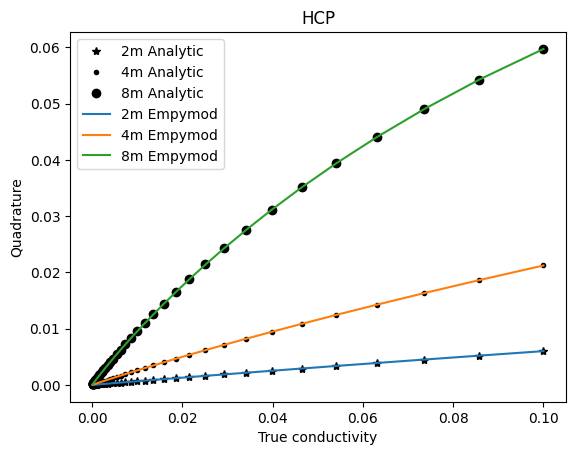

In [34]:
plt.figure()
plt.plot(sgm[0], np.imag(ZHCP[0,:]), '*k',label = '2m Analytic' )
plt.plot(sgm[0], np.imag(ZHCP[1,:]), '.k',label = '4m Analytic' )
plt.plot(sgm[0], np.imag(ZHCP[2,:]), 'ok',label = '8m Analytic' )
plt.plot(sgm[0], np.imag(ZHCP_empy[0,:]), label = '2m Empymod' )
plt.plot(sgm[0], np.imag(ZHCP_empy[1,:]), label = '4m Empymod' )
plt.plot(sgm[0], np.imag(ZHCP_empy[2,:]), label = '8m Empymod' )
plt.legend()
plt.xlabel('True conductivity')
plt.ylabel('Quadrature')
plt.title('HCP')


Text(0.5, 1.0, 'VCP')

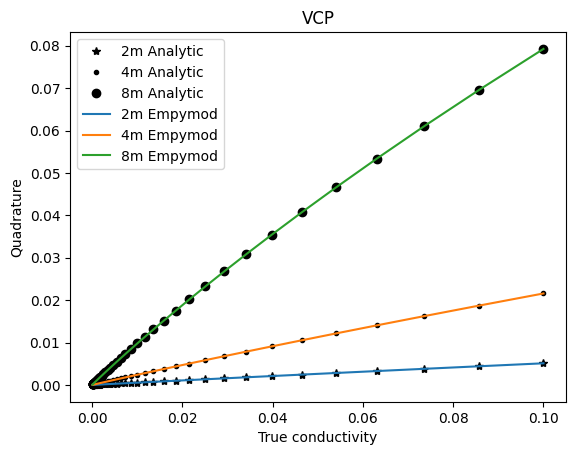

In [35]:
plt.figure()
plt.plot(sgm[0], np.imag(ZVCP[0,:]), '*k',label = '2m Analytic' )
plt.plot(sgm[0], np.imag(ZVCP[1,:]), '.k',label = '4m Analytic' )
plt.plot(sgm[0], np.imag(ZVCP[2,:]), 'ok',label = '8m Analytic' )
plt.plot(sgm[0], np.imag(ZVCP_empy[0,:]), label = '2m Empymod' )
plt.plot(sgm[0], np.imag(ZVCP_empy[1,:]), label = '4m Empymod' )
plt.plot(sgm[0], np.imag(ZVCP_empy[2,:]), label = '8m Empymod' )

plt.legend()
plt.xlabel('True conductivity')
plt.ylabel('Quadrature')
plt.title('VCP')
